In [1]:
!pip install accelerate

     |████████████████████████████████| 58 kB 566 kB/s            


In [2]:
import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator
from transformers import (AutoModel,AutoTokenizer,AdamW,AutoModelForSequenceClassification,
                          AutoConfig,get_cosine_schedule_with_warmup)

from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

In [3]:
group_map = {
    "LF":0,
    "MF":1,
    "UF":2,
    "competitor":3,
    "brand":4}

map_group = {
    0:"LF",
    1:"MF",
    2:"UF",
    3:"competitor",
    4:"brand"}

csv_path = '../input/google-ads-keyword-grouping2/fold{}.csv'
train_data = pd.DataFrame()
for i in range(5):
    df = pd.read_csv(csv_path.format(i))
    train_data = train_data.append(df)

train_data['target'] = train_data['Grouping'].map(group_map)
train_data.head()

,Keyword,Grouping,Fold,target
0,grout sealant lowes,competitor,0,3
1,endurable concrete sealer,LF,0,0
2,glaze guard sealer,LF,0,0
3,gloss porcelain tile sealer,LF,0,0
4,linoleum floor sealer,LF,0,0


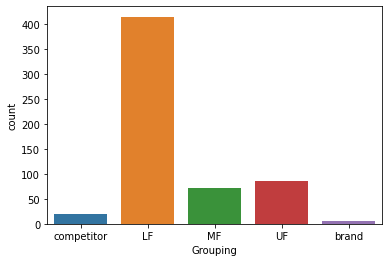

In [4]:
sns.countplot(train_data["Grouping"]);

In [5]:
config = {
    'lr': 1.1e-5,
    'wd':1e-2,
    'batch_size':8,
    'valid_step':10,
    'num_workers':4,
    'max_len':10,
    'epochs':10,
    'nfolds':5,
    'seed':1000,
    'model_path':'roberta-large'
}

for i in range(config['nfolds']):
    os.makedirs(f'model{i}',exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

In [6]:
class GadsDataset(Dataset):
    def __init__(self,df,tokenizer,max_len=128):
        self.keywords = df['Keyword'].to_numpy()
        self.targets = df['target'].to_numpy()
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.keywords[idx],
                                return_tensors='pt',
                                add_special_tokens = True,
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        
        target = torch.tensor(self.targets[idx],dtype=torch.long) 
        return encode, target
    
    def __len__(self):
        return len(self.keywords)

In [7]:
def run(fold):
    
    loss_fn = nn.CrossEntropyLoss()
    
    def evaluate(model,valid_loader):
        model.eval()
        valid_loss = 0
        all_targets, all_outputs = [], []
        with torch.no_grad():
            for i, (inputs,targets) in enumerate(valid_loader):
                inputs = {key:val.reshape(val.shape[0],-1) for key,val in inputs.items()}
                inputs['labels'] = targets
                outputs = model(**inputs)
                outputs,loss = outputs['logits'],outputs['loss']
                valid_loss += loss.item()
                all_outputs.extend(outputs.cpu().detach().numpy().tolist())
                all_targets.extend(targets.cpu().detach().numpy().tolist())

        valid_loss /= len(valid_loader)
        all_targets = np.array(all_targets)
        all_outputs = np.array(all_outputs).argmax(axis=1)
        valid_acc = accuracy_score(all_targets,all_outputs)
        return valid_loss,valid_acc
        
    def train_and_evaluate_loop(train_loader,valid_loader,model,loss_fn,optimizer,
                                epoch,fold,best_loss,best_score,lr_scheduler=None):
        train_loss = 0
        for i, (inputs,targets) in enumerate(train_loader):
            optimizer.zero_grad()
            model.train()
            inputs = {key:val.reshape(val.shape[0],-1) for key,val in inputs.items()}
            inputs['labels'] = targets
            outputs = model(**inputs)
            ouptuts,loss = outputs['logits'],outputs['loss']
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if lr_scheduler:
                lr_scheduler.step()
                
        valid_loss,valid_acc = evaluate(model,valid_loader) 

        print(f"Epoch:{epoch}|Train Loss:{train_loss/(i+1)}|Valid Loss:{valid_loss}|Valid Acc:{valid_acc}")        

        if valid_loss < best_loss:
            print(f"{g_} Loss Decreased from {best_loss} to {valid_loss}{sr_}")
            best_loss = valid_loss
        
        if valid_acc > best_score:
            print(f"{y_} New best accuracy score: {valid_acc}{sr_}")
            best_score = valid_acc
            torch.save(model.state_dict(),f'./model{fold}/model{fold}.bin')
            tokenizer.save_pretrained(f'./model{fold}')
                    
        return best_loss,best_score
        
    accelerator = Accelerator()
    print(f"{accelerator.device} is used")
    
    x_train,x_valid = train_data.query(f"Fold != {fold}"),train_data.query(f"Fold == {fold}")
    
    model = AutoModelForSequenceClassification.from_pretrained(config['model_path'],num_labels = 5)
    tokenizer = AutoTokenizer.from_pretrained(config['model_path'])
    
    train_ds = GadsDataset(x_train,tokenizer,config['max_len'])
    train_dl = DataLoader(train_ds,
                        batch_size = config["batch_size"],
                        num_workers = config['num_workers'],
                        shuffle=True,
                        pin_memory=True,
                        drop_last=True)

    valid_ds = GadsDataset(x_valid,tokenizer,config['max_len'])
    valid_dl = DataLoader(valid_ds,
                        batch_size = config["batch_size"],
                        num_workers = config['num_workers'],
                        shuffle=False,
                        pin_memory=True,
                        drop_last=False)
        
    optimizer = AdamW(model.parameters(),lr=config['lr'],weight_decay=config['wd']) 
    lr_scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= config['epochs'] * len(train_dl))

    model,train_dl,valid_dl,optimizer,lr_scheduler = accelerator.prepare(model,train_dl,valid_dl,optimizer,lr_scheduler)

    print(f"Fold: {fold}")
    best_loss = np.inf
    best_score = -np.inf
    start_time = time.time()
    for epoch in range(config["epochs"]):
        print(f"Epoch Started:{epoch}")
        best_loss,best_score = train_and_evaluate_loop(train_dl,valid_dl,model,loss_fn,optimizer,epoch,fold,
                                             best_loss,best_score,lr_scheduler)
        
        end_time = time.time()
        print(f"{m_}Time taken by epoch {epoch} is {end_time-start_time:.2f}s{sr_}")
        start_time = end_time
        
    return best_score

In [8]:
best_score_per_fold = [run(f) for f in range(config['nfolds'])]

cuda is used


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Fold: 0
Epoch Started:0
Epoch:0|Train Loss:1.0146874588424877|Valid Loss:0.7589478974541028|Valid Acc:0.6974789915966386
 Loss Decreased from inf to 0.7589478974541028
 New best accuracy score: 0.6974789915966386
Time taken by epoch 0 is 12.47s
Epoch Started:1
Epoch:1|Train Loss:0.7365889083278381|Valid Loss:0.6726136816044649|Valid Acc:0.8067226890756303
 Loss Decreased from 0.7589478974541028 to 0.6726136816044649
 New best accuracy score: 0.8067226890756303
Time taken by epoch 1 is 13.30s
Epoch Started:2
Epoch:2|Train Loss:0.5295870645382141|Valid Loss:0.5930764668310682|Valid Acc:0.8823529411764706
 Loss Decreased from 0.6726136816044649 to 0.5930764668310682
 New best accuracy score: 0.8823529411764706
Time taken by epoch 2 is 19.69s
Epoch Started:3
Epoch:3|Train Loss:0.31282072312245934|Valid Loss:0.3805641691510876|Valid Acc:0.907563025210084
 Loss Decreased from 0.5930764668310682 to 0.3805641691510876
 New best accuracy score: 0.907563025210084
Time taken by epoch 3 is 22.24s


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

Fold: 1
Epoch Started:0
Epoch:0|Train Loss:1.002216762910455|Valid Loss:0.736547439545393|Valid Acc:0.6974789915966386
 Loss Decreased from inf to 0.736547439545393
 New best accuracy score: 0.6974789915966386
Time taken by epoch 0 is 12.55s
Epoch Started:1
Epoch:1|Train Loss:0.7620006746659844|Valid Loss:0.5791815636058648|Valid Acc:0.8487394957983193
 Loss Decreased from 0.736547439545393 to 0.5791815636058648
 New best accuracy score: 0.8487394957983193
Time taken by epoch 1 is 12.93s
Epoch Started:2
Epoch:2|Train Loss:0.48973151744674825|Valid Loss:0.4900638746097684|Valid Acc:0.865546218487395
 Loss Decreased from 0.5791815636058648 to 0.4900638746097684
 New best accuracy score: 0.865546218487395
Time taken by epoch 2 is 20.45s
Epoch Started:3
Epoch:3|Train Loss:0.30794744749190445|Valid Loss:0.35426328467826046|Valid Acc:0.8991596638655462
 Loss Decreased from 0.4900638746097684 to 0.35426328467826046
 New best accuracy score: 0.8991596638655462
Time taken by epoch 3 is 21.19s
E

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

Fold: 2
Epoch Started:0
Epoch:0|Train Loss:1.0470482297873094|Valid Loss:0.7472325205802918|Valid Acc:0.6974789915966386
 Loss Decreased from inf to 0.7472325205802918
 New best accuracy score: 0.6974789915966386
Time taken by epoch 0 is 12.97s
Epoch Started:1
Epoch:1|Train Loss:0.6801399049364915|Valid Loss:0.5105627899368604|Valid Acc:0.8823529411764706
 Loss Decreased from 0.7472325205802918 to 0.5105627899368604
 New best accuracy score: 0.8823529411764706
Time taken by epoch 1 is 12.95s
Epoch Started:2
Epoch:2|Train Loss:0.37408551472728535|Valid Loss:0.36325202298661075|Valid Acc:0.865546218487395
 Loss Decreased from 0.5105627899368604 to 0.36325202298661075
Time taken by epoch 2 is 9.18s
Epoch Started:3
Epoch:3|Train Loss:0.22387135030417624|Valid Loss:0.4075939065621545|Valid Acc:0.8907563025210085
 New best accuracy score: 0.8907563025210085
Time taken by epoch 3 is 13.19s
Epoch Started:4
Epoch:4|Train Loss:0.16091730181222497|Valid Loss:0.31547699254006145|Valid Acc:0.915966

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

Fold: 3
Epoch Started:0
Epoch:0|Train Loss:0.9727585729906114|Valid Loss:0.7827379256486893|Valid Acc:0.6974789915966386
 Loss Decreased from inf to 0.7827379256486893
 New best accuracy score: 0.6974789915966386
Time taken by epoch 0 is 12.71s
Epoch Started:1
Epoch:1|Train Loss:0.6818251285260006|Valid Loss:0.5120233575503031|Valid Acc:0.8235294117647058
 Loss Decreased from 0.7827379256486893 to 0.5120233575503031
 New best accuracy score: 0.8235294117647058
Time taken by epoch 1 is 12.75s
Epoch Started:2
Epoch:2|Train Loss:0.36864474706225475|Valid Loss:0.3496590713659922|Valid Acc:0.907563025210084
 Loss Decreased from 0.5120233575503031 to 0.3496590713659922
 New best accuracy score: 0.907563025210084
Time taken by epoch 2 is 20.63s
Epoch Started:3
Epoch:3|Train Loss:0.2766092618359095|Valid Loss:0.3137104963262876|Valid Acc:0.8907563025210085
 Loss Decreased from 0.3496590713659922 to 0.3137104963262876
Time taken by epoch 3 is 9.12s
Epoch Started:4
Epoch:4|Train Loss:0.177071261

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

Fold: 4
Epoch Started:0
Epoch:0|Train Loss:0.969742159722215|Valid Loss:0.7059172061582406|Valid Acc:0.6974789915966386
 Loss Decreased from inf to 0.7059172061582406
 New best accuracy score: 0.6974789915966386
Time taken by epoch 0 is 13.00s
Epoch Started:1
Epoch:1|Train Loss:0.6431376858282898|Valid Loss:0.40567729622125626|Valid Acc:0.865546218487395
 Loss Decreased from 0.7059172061582406 to 0.40567729622125626
 New best accuracy score: 0.865546218487395
Time taken by epoch 1 is 12.78s
Epoch Started:2
Epoch:2|Train Loss:0.36441205542976574|Valid Loss:0.3690338357662161|Valid Acc:0.8991596638655462
 Loss Decreased from 0.40567729622125626 to 0.3690338357662161
 New best accuracy score: 0.8991596638655462
Time taken by epoch 2 is 33.02s
Epoch Started:3
Epoch:3|Train Loss:0.2063328358739362|Valid Loss:0.3202495856986692|Valid Acc:0.9243697478991597
 Loss Decreased from 0.3690338357662161 to 0.3202495856986692
 New best accuracy score: 0.9243697478991597
Time taken by epoch 3 is 12.95

In [9]:
print("Mean score is",np.mean(best_score_per_fold))

Mean score is 0.9327731092436975


## Making Predictions

In [10]:
test_data = pd.read_csv('../input/google-ads-keyword-grouping2/test_df.csv')

In [11]:
class GadsTestDataset(Dataset):
    def __init__(self,df,tokenizer):
        self.keywords = df['Keyword'].to_numpy()
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.keywords[idx],return_tensors='pt',
                                max_length=config['max_len'],
                                padding='max_length',truncation=True)
        return encode
    
    def __len__(self):
        return len(self.keywords)

In [12]:
def get_prediction(df,path,model_path,device='cuda'):        
    model = AutoModelForSequenceClassification.from_pretrained(config['model_path'],num_labels = 5)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    predictions = list()
    
    for f in range(config['nfolds']):
        model.load_state_dict(torch.load(path.format(f),map_location=device))
        model.to(device)
        model.eval()

        test_ds = GadsTestDataset(df,tokenizer)
        test_dl = DataLoader(test_ds,
                            batch_size = config["batch_size"],
                            shuffle=False,
                            drop_last=False,
                            num_workers = 4,
                            pin_memory=True)

        with torch.no_grad():
            pred = list()
            for i, (inputs) in tqdm(enumerate(test_dl)):
                inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
                outputs = model(**inputs)
                outputs = outputs['logits'].cpu().detach().numpy().tolist()
                pred.extend(outputs)
            predictions.append(pred)
            
    torch.cuda.empty_cache()
    final_predictions = np.mean(predictions,axis=0)
    return np.mean(predictions,axis=0)

In [13]:
model_paths = [
    ['./model{0}/model{0}.bin',config['model_path']],
]

In [14]:
predictions = np.zeros((test_data.shape[0],5))
for path,model_path in model_paths:
    predictions += get_prediction(test_data,path,model_path)/len(model_paths)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

In [15]:
predictions = np.argmax(predictions,axis=1)

In [16]:
test_data['target'] = predictions
test_data['Grouping'] = test_data['target'].map(map_group)

In [17]:
test_data.head()

,Keyword,target,Grouping
0,sealant for tiles,0,LF
1,tile sealer,0,LF
2,how to seal grout,2,UF
3,grout sealer home depot,3,competitor
4,best grout sealer,1,MF


In [18]:
test_data.to_csv('test_df.csv',index=False)